In [111]:
import numpy as np
import matplotlib.pyplot as plt

In [112]:
class Reward():
    def __init__(self, mean, var):
        self.m = mean
        self.var = var
    
    def get_reward(self):
        return np.random.normal(loc=self.m, scale=np.sqrt(self.var))

In [113]:
class NArmedBanditEnvironment():
    def __init__(self, arm_count, R_mean, R_std):
        self.arm_count = arm_count
        self.rewards = [Reward(R_mean[i], R_std[i]) for i in range(arm_count)]
        self.agents_last_choice = []
        self.optimal_action = np.argmax(R_mean)
        self.agents_last_choice = []
    
    def add_agent(self):
        self.agents_last_choice.append(-1) 
     
    def calculate_reward(self, action):
        return self.rewards[action].get_reward()
    
    def update_selected(self, action, agent_id):
        if agent_id == -1:
            return
        self.agents_last_choice[agent_id] = action
        
    def step(self, action, agent_id):
        reward = self.calculate_reward(action)
        observation = self.observe(agent_id)
        self.update_selected(action, agent_id)
        return observation, reward
    def observe(self,agent_id):
        return #np.delete(np.copy(self.agents_last_choice),agent_id)
    def config(self):
        self.agents_last_choice = []

Individual learning methods:

In [114]:
class ThompsonAgent:
    def __init__(self, id, environment, uf = [1,1,1,1], Ts_mean = 0, Ts_var = 1000):
        self.id = id
        self.uf = uf
        self.environment = environment
        self.environment.add_agent()
        self.Ts_rewards = []
        self.rewards_sum = np.zeros(self.environment.arm_count)
        self.rewards_count = np.zeros(self.environment.arm_count)
        for i in range(self.environment.arm_count):
            self.Ts_rewards.append(Reward(Ts_mean,Ts_var))
    def select_action(self):
        sample = [self.Ts_rewards[i].get_reward() for i in range(self.environment.arm_count)]
        return np.argmax(sample)
    def update_arm(self, Ri, index):
        self.rewards_sum[index] = self.rewards_sum[index] + Ri
        self.rewards_count[index] = self.rewards_count[index] + 1
        tau = 1/self.Ts_rewards[index].var
        self.Ts_rewards[index].m = (self.Ts_rewards[index].m * tau + self.rewards_sum[index])/ (self.rewards_count[index] + tau)
        tau = tau + 1
        self.Ts_rewards[index].var = 1/tau
    def take_action(self):
        index_selected_arm = self.select_action()
        obs, Ri = self.environment.step(index_selected_arm,self.id)
        self.update_arm(Ri, index_selected_arm)
        return obs, Ri, index_selected_arm
class greedyAgent:
    def __init__(self, id, environment, uf = [1,1,1,1]):
        self.id = id
        self.uf = uf
        # Step count
        self.n = 0
        self.environment = environment
        if id != -1:
            self.environment.add_agent()
        self.k = environment.arm_count
        # Step count for each arm
        self.k_n = np.zeros(self.k)
        # Total mean reward
        self.mean_reward = 0
        # Mean reward for each arm
        self.k_reward = np.zeros(self.k)
    def select_action(self):
        p = np.random.rand()
        if p < 1 / (1 + self.n / self.k):
            return np.random.choice(self.k)
        else:
            return np.argmax(self.k_reward)
    
    
    def UF(self, Ri):
        if Ri > 0:
            return self.uf[0]*Ri**self.uf[1]
        if Ri < 0:
            return -1*self.uf[3]*(-1*Ri)**self.uf[2]
        return 0
    
    def take_action(self):
        index_selected_arm = self.select_action()
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        Ri = self.UF(Ri)
        self.n += 1
        self.k_n[index_selected_arm] += 1
        self.mean_reward = self.mean_reward + (Ri - self.mean_reward) / self.n
        self.k_reward[index_selected_arm] = self.k_reward[index_selected_arm] + (Ri - self.k_reward[index_selected_arm]) / self.k_n[index_selected_arm]
        return obs, Ri, index_selected_arm
    def update_arm(self, Ri, index_selected_arm):
        self.n += 1
        self.k_n[index_selected_arm] += 1
        self.mean_reward = self.mean_reward + (Ri - self.mean_reward) / self.n
        self.k_reward[index_selected_arm] = self.k_reward[index_selected_arm] + (Ri - self.k_reward[index_selected_arm]) / self.k_n[index_selected_arm]
class  BoltzmannAgent():
    
    def __init__(self, id, environment):
        self.environment = environment
        self.environment.add_agent()
        self.temp_pull_count   = np.zeros(environment.arm_count)
        self.temp_estimation   = np.zeros(environment.arm_count) + 1/environment.arm_count
        self.id = id
        self.tempture = 10
        
    def select_action(self):
        pi  = np.exp(self.temp_estimation/self.tempture) / np.sum(np.exp(self.temp_estimation/self.tempture))
        current_choice = np.random.choice(self.environment.arm_count,p=pi)
        return current_choice
    
    def update_arm(self, Ri, current_choice):
        self.temp_pull_count[current_choice] = self.temp_pull_count[current_choice] + 1
        self.temp_estimation[current_choice] = self.temp_estimation[current_choice] + (1/(self.temp_pull_count[current_choice]+1)) * (Ri-self.temp_estimation[current_choice])
        if self.tempture > 1:
            self.tempture = self.tempture * 0.9
        else:
            self.tempture =  0.1
        return
    
    def take_action(self):
        index_selected_arm = self.select_action()
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        self.update_arm(Ri, index_selected_arm)
        return obs, Ri, index_selected_arm
class gradientAgent():
    
    def __init__(self, id, environment, alpha = 0.1):
        self.environment = environment
        self.environment.add_agent()
        self.k = self.environment.arm_count
        self.actions = np.arange(self.k)
        self.n = 1
        self.k_n = np.ones(self.k)
        self.mean_reward = 0
        self.k_reward = np.zeros(self.k)
        self.H = np.zeros(self.k)
        self.alpha = alpha
        self.id = id
        self.prob_action = np.exp(self.H - np.max(self.H)) \
            / np.sum(np.exp(self.H - np.max(self.H)), axis=0)
    
    def softmax(self):
        self.prob_action = np.exp(self.H - np.max(self.H)) \
            / np.sum(np.exp(self.H - np.max(self.H)), axis=0)

    def select_action(self):
      # Update probabilities
        self.softmax()
        # Select highest preference action
        a = np.random.choice(self.actions, p=self.prob_action)
        return a
    def update_arm(self, reward, a):
        # Update counts
        self.n += 1
        self.k_n[a] += 1
         
        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
         
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]
         
        # Update preferences
        self.H[a] = self.H[a] + self.alpha * (reward - self.mean_reward) * (1 - self.prob_action[a])
        actions_not_taken = self.actions!=a
        self.H[actions_not_taken] = self.H[actions_not_taken] - self.alpha * (reward - self.mean_reward) * self.prob_action[actions_not_taken]

        
    def take_action(self):
        a = self.select_action()  
        obs, reward = self.environment.step(a, self.id)
        self.update_arm(reward, a)
        return obs, reward, a

class UCB():
    def __init__(self, id, environment,c_level = 0.9):
        self.actions_range = range(environment.arm_count)
        self.actions = [i for i in self.actions_range]
        self.Q = [0 for i in self.actions_range]
        self.n = [0 for i in self.actions_range]
        self.UCBs = [float('inf') for i in self.actions_range]
        self.total_reward = 0
        self.confidence_level=c_level
        self.iteration = 0
        self.environment = environment
        environment.add_agent()
        self.trial = 0
        

    def uncertainty(self, iteration, index):
        if self.n[index] == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(iteration) / self.n[index])) 


    def update_ucb(self, iteration, index):
        self.UCBs[index] =  self.Q[index] + self.uncertainty(iteration,index)
        return

    def update_belief(self, i, R):
        self.trial +=1
        self.n[i] +=1
        self.Q[i] = (1 - 1.0/self.n[i]) * self.Q[i]+ (1.0/(self.n[i]+1)) * R
        return

    def get_total_reward(self, R):
        self.total_reward += R
        return self.total_reward

    def get_optimal(self, index_of_Q):
        self.optimal[self.trial-1] = self.n[index_of_Q]/ self.trial

    def select_action(self):
      return np.argmax(self.UCBs)

    def update_arm(self, Ri, index_selected_arm):
      self.update_belief(index_selected_arm, Ri)
      self.update_ucb(self.iteration,index_selected_arm)



    def take_action(self) -> (object, float, bool, object):
        self.iteration += 1
        available_actions = [ i for i in range(self.environment.arm_count)]
        action = self.select_action()
        obs, r = self.environment.step(action,0)
        self.update_belief( action, r)
        self.update_ucb(self.iteration,action)
        return obs, r, action

Coded agents:

In [115]:
class alwaysBestAgent():
    def __init__(self,environment, alpha, uf, id):
        self.t = 0
        self.environment = environment
        self.environment.add_agent()
        self.id = id
        self.bestaction = np.argmax([r.m for r in self.environment.rewards]) #+  self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.worstreward = self.environment.rewards[np.argmin([r.m for r in self.environment.rewards])].m #- self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.regret = []
        
        
        
    def take_action(self):
        index_selected_arm = self.bestaction
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        #self.r = self.r + self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].m - self.environment.rewards[indx].m
        #self.regret.append(self.r)
        
        return obs, Ri, index_selected_arm
    
class percentBestAgent():
    def __init__(self,environment, alpha, uf, id, p, increase = 0, limit = 1, zero_at = False):
        self.t = 0
        self.environment = environment
        self.environment.add_agent()
        self.id = id
        self.bestaction = np.argmax([r.m for r in self.environment.rewards]) #+  self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.worstreward = self.environment.rewards[np.argmin([r.m for r in self.environment.rewards])].m #- self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.regret = []
        self.p = p
        self.increase = increase
        self.zero_at = zero_at
        self.limit = limit
        
        
    def take_action(self):
        if np.random.rand()<self.p:
            index_selected_arm = self.bestaction
        else:
            index_selected_arm = np.random.choice([i for i in range(self.environment.arm_count)])
        self.p = self.p + self.increase
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        #self.r = self.r + self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].m - self.environment.rewards[indx].m
        #self.regret.append(self.r)
        if self.p > self.limit:
            self.p = self.limit
            self.increase = 0
        if self.zero_at:
            if self.p > 1:
                self.p = 0
                self.increase = 0
        return obs, Ri, index_selected_arm
    
class secondBestAgent():
    def __init__(self,environment, alpha, uf, id):
        self.t = 0
        self.environment = environment
        self.environment.add_agent()
        self.id = id
        self.bestaction = np.array([r.m for r in self.environment.rewards]).argsort()[-2] #+  self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.worstreward = self.environment.rewards[np.argmin([r.m for r in self.environment.rewards])].m #- self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.regret = []
        
        
        
    def take_action(self):
        index_selected_arm = self.bestaction
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        return obs, Ri, index_selected_arm   
    
class alwaysWorstAgent():
    def __init__(self,environment, id):
        self.t = 0
        self.environment = environment
        self.environment.add_agent()
        self.id = id
        self.bestaction = np.argmin([r.m for r in self.environment.rewards]) #+  self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.worstreward = self.environment.rewards[np.argmin([r.m for r in self.environment.rewards])].m #- self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.regret = []
        
        
        
    def take_action(self):
        index_selected_arm = self.bestaction
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        return obs, Ri, index_selected_arm

class alwaysRandomAgent():
    def __init__(self,environment, id):
        self.t = 0
        self.environment = environment
        self.environment.add_agent()
        self.id = id
        self.bestaction = np.argmin([r.m for r in self.environment.rewards]) #+  self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.worstreward = self.environment.rewards[np.argmin([r.m for r in self.environment.rewards])].m #- self.environment.rewards[np.argmax([r.m for r in self.environment.rewards])].var
        self.regret = []
        
        
        
    def take_action(self):
        index_selected_arm = np.random.choice(self.environment.arm_count)
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        return obs, Ri, index_selected_arm

In [116]:
class SocialAgent():
    def __init__(self,environment, alpha, id, preferencelearner= None, noize = 0, limit = 100000):
        self.environment = environment
        self.individual = greedyAgent(environment = environment,id = id)
        self.id = id
        self.preference = np.zeros(len(self.environment.agents_last_choice))+0.0001
        self.prob = 10
        self.history = []
        # Total mean reward
        self.mean_reward = 0
        self.n = 0
        # Mean reward for each arm
        self.preference_history = {}
        self.frequency = np.zeros((len(self.environment.agents_last_choice),environment.arm_count))
        self.noize = noize
        self.limit = limit
        for i in range(len(self.preference)):
            self.preference_history[i] = []
        
    def update_social_preference(self, index, Ri, index_selected_arm, alpha = 0.1):
        '''Update others with same action selected:'''
        #alpha = 1/len(self.environment.agents_last_choice)
        same = [i for i in range(len(self.environment.agents_last_choice)) if self.environment.agents_last_choice[i]==index_selected_arm]
        #same.remove(self.id)
        if self.id not in same:
            if self.individual.select_action() == index_selected_arm:
                same.append(self.id)
        self.preference = np.round(self.preference,2)
        d = np.sum(np.exp(self.preference))
        mask = np.ones(len(self.preference))*alpha
        self.preference = self.preference - mask * (Ri - self.mean_reward) * np.exp(self.preference)/d
        for index in same:
            self.preference[index] = self.preference[index] + alpha * (Ri - self.mean_reward)
        return
    
    def select_agent_social(self):
        '''calculate action frequency'''
        for i in range(len(self.preference)):
            self.frequency[i][self.environment.agents_last_choice[i]] += 1
        p = np.round(np.exp(np.round(self.preference,2)),2)
        p = p/np.sum(p)
        for j in range(len(p)):
            if np.isnan(p[j]):
                p[j] = 1
        for i in range(len(self.preference)):
            self.preference_history[i].append(p[i]/np.sum(p))
        ind = np.random.choice(len(self.preference),p = p/np.sum(p))
        return ind
    
    def take_action_social(self) -> (object, float):
        ind = self.select_agent_social()
        if ind == self.id or len(self.environment.agents_last_choice)==1 or self.n > self.limit:
            self.history.append(-1)
            index_selected_arm = self.individual.select_action()
            obs, Ri = self.environment.step(index_selected_arm, self.id)
            self.individual.update_arm(Ri, index_selected_arm)
        else:
            '''select most frequent'''
            self.history.append(ind)
            index_selected_arm = self.environment.agents_last_choice[ind]
            #np.argmax(self.frequency[ind])
            if np.random.rand() < self.noize:
                index_selected_arm = np.random.choice([i for i in range(self.environment.arm_count) if i != index_selected_arm])
            obs, Ri = self.environment.step(index_selected_arm, self.id)
            self.individual.update_arm(Ri, index_selected_arm)
        self.n += 1
        self.mean_reward = self.mean_reward + (Ri - self.mean_reward) / self.n
        self.update_social_preference(ind,Ri, index_selected_arm)
        return obs, Ri, index_selected_arm
    
    def take_action(self):
        obs, Ri, indx = self.take_action_social()
        return obs, Ri, indx

In [117]:
class Sciety():
    def __init__(self, env=None, thompson_agent = 0, percent_agents = 1, p = [0.01], increase = [0.005], limit = [0.9], worst_agents = 1, random_agents = 4, UCBagent = 0):
        self.agents = []
        self.names = []
        self.thompson_agent, self.percent_agents , self.p , self.increase , self.limit, self.worst_agents , self.random_agents, self.env = thompson_agent , percent_agents , p , increase , limit , worst_agents , random_agents, env
        self.historyTotal = {}
        self.UCBagent = UCBagent
        for i in range(thompson_agent+percent_agents+worst_agents+random_agents +UCBagent):
            self.historyTotal[i] = []
        self.historyTotalR = {}
        for i in range(thompson_agent+percent_agents+worst_agents+random_agents +UCBagent):
            self.historyTotalR[i] = []
        
    def reset(self, env):
        self.env = env
        self.agents = []
        self.names = []
        for i in range(self.UCBagent):
            self.agents.append(UCB(environment = self.env,id = len(self.agents)))
        for i in range(self.thompson_agent):
            self.agents.append(ThompsonAgent(environment = self.env,id = len(self.agents)))
            self.names.append("thompson")
        for i in range(self.random_agents):
            self.agents.append(alwaysRandomAgent(self.env,len(self.agents)))
            self.names.append("random")
        for i in range(self.percent_agents):
            self.agents.append(percentBestAgent(self.env,0.1,[1,1,1,1],len(self.agents), self.p[i], self.increase[i],self.limit[i]))
            self.names.append("percent("+str(self.p[i])+","+str(self.increase[i])+","+str(self.limit[i])+")")
        for i in range(self.worst_agents):
            self.agents.append(alwaysWorstAgent(self.env,len(self.agents)))
            self.names.append("worst")
        self.history = {}
        for i in range(len(self.agents)):
            self.history[i] = []
        self.historyR = {}
        for i in range(len(self.agents)):
            self.historyR[i] = []
        
    def step(self):
        for a in range(len(self.agents)):
            obs, Ri, index_selected_arm = self.agents[a].take_action()
            self.history[a].append(index_selected_arm)
            self.historyR[a].append(Ri)
    def historyRecord(self):
        for a in range(len(self.agents)):
            self.historyTotal[a].append(self.history[a])
            self.historyTotalR[a].append(self.historyR[a])
        self.history = {}
        for i in range(len(self.agents)):
            self.history[i] = []
        self.historyR = {}
        for i in range(len(self.agents)):
            self.historyR[i] = []
    def getCategories(self):
        temp = {}
        index = []
        for n in range(len(self.names)):
            if self.names[n] not in temp.keys() or "percent" in self.names[n]:
                temp[self.names[n]] = 0
                index.append(n)
        return index

In [118]:
class SocialLearning:
    def __init__(self, learner, society, individual, k_n_thr = 0, limit = 10000):
        self.learner = learner
        self.society = society
        self.individual = individual
        self.history = []
        self.historyR = []
        self.historyindividual = []
        self.historyindividualR = []
        self.best = []
        self.bestR = []
        self.preference_history = {}
        self.id = 0
        self.k_n_thr = k_n_thr
        self.limit = limit

    def iteration(self, env, trial_cnt, preferencelearner, threshold = 1000, noize = 0):
        self.society.reset(env)
        history = []
        historyR = []
        historyindividual = []
        historyindividualR = []
        if env.arm_count/len(self.society.agents) > self.k_n_thr:
            socialLearner = self.learner(env,0.1,len(self.society.agents), preferencelearner, noize, self.limit)
            self.id = socialLearner.id
        else:
            socialLearner = self.individual(environment = env,id = 0)
        for i in range(trial_cnt):
            self.society.step()
            obs, Ri, index_selected_arm = socialLearner.take_action()
            history.append(index_selected_arm)
            historyR.append(Ri)
        if env.arm_count/len(self.society.agents) > self.k_n_thr:
            for i in range(len(socialLearner.preference_history)):
                self.preference_history[i].append(socialLearner.preference_history[i])
        individualLearner = self.individual(environment = env,id = 0)
        for i in range(trial_cnt):
            obs, Ri, index_selected_arm = individualLearner.take_action()
            historyindividual.append(index_selected_arm)
            historyindividualR.append(Ri)
        self.historyindividual.append(historyindividual)
        self.historyindividualR.append(historyindividualR)
        self.society.historyRecord()
        self.history.append(history)
        self.historyR.append(historyR)
    def loop(self, epoch = 10, iteration = 10, vars = [], rewards = [(i-100)/10 for i in range(200)], threshold = 1000, noize = 0, n = [100], reward_var = None, reward_means = None, random_reward = True, k = None, preferencelearner = None):
        for i in range(len(self.society.historyTotal.keys())+1):
            self.preference_history[i] = []
        for (reward_means,reward_var) in zip(rewards, vars):
            for i in range(iteration):               
                env = NArmedBanditEnvironment(len(reward_means), reward_means, reward_var)
                self.iteration(env, 1000, preferencelearner)
                self.best.append(np.argmax(reward_means))
                self.bestR.append(np.max(reward_means))
    def optimalaction(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [0]
            for index_selected_arm in hist[i]:
                temp.append(temp[-1]+int(index_selected_arm==self.best[i]))
            temp = temp[1:]
            for t in range(len(temp)):
                temp[t] = temp[t]/(t+1)
            poa.append(temp)
        return poa
    def regret(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [((j+1)*self.bestR[i]-np.sum(hist[i][0:j])) for j in range(len(hist[i]))]
            poa.append(temp)
        return poa
    def creward(self, hist):
        poa = []
        for i in range(len(hist)):
            poa.append(hist[i])
        return poa
    def regretc(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [(self.bestR[i]-hist[i][j]) for j in range(len(hist[i]))]
            poa.append(temp)
        return poa
    def compare(self, all = False):
        if all:
            index = [i for i in range(len(self.society.agents))]
        else:
            index = self.society.getCategories()
        data = {}
        data["history action"] = self.history
        data["history reward"] = self.historyR
        data["index"] = index
        data["history individual action"] = self.historyindividual
        data["history individual reward"] = self.historyindividualR
        data["optimal action"] = self.best
        data["optimal action reward"] = self.bestR
        tmp = {}
        tmp["social"] = self.preference_history[self.id]
        for i in index:
            tmp[self.society.names[i]] = self.preference_history[i]
        data["preference"] = tmp
        poa = {}
        poa["social"] = self.optimalaction(self.history)
        poa["individual"] = self.optimalaction(self.historyindividual)
        for i in index:
            poa[self.society.names[i]] = self.optimalaction(self.society.historyTotal[i])
        data["percent of selecting the optimal action"] = poa
        poa = {}
        poa["social"] = self.regret(self.historyR)
        poa["individual"] = self.regret(self.historyindividualR)
        data["regret"] = poa
        poa = {}
        poa["social"] = self.regretc(self.historyR)
        poa["individual"] = self.regretc(self.historyindividualR)
        data["regretc"] = poa
        poa = {}
        poa["social"] = self.creward(self.historyR)
        poa["individual"] = self.creward(self.historyindividualR)
        data["creward"] = poa
        return data

### Visualization

In [119]:
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
class tools:
    def __init__(self):
        drive.mount('/content/gdrive')
    def Visual(self, data, t = 1000, save = False, name = "", std = True, limit = True, line = True, label = "difference of the percent of best action selection social and individual"):
        fig, ax = plt.subplots()
        clrs = sns.color_palette("husl", len(data.keys()))
        with sns.axes_style("darkgrid"):
            epochs = list(range(t))
            for (x, c) in zip(data.keys(),clrs):
                meanst = np.mean(data[x],axis = 0)
                sdt = 2*np.std(data[x], axis = 0, ddof = 0)/np.sqrt(np.shape(data[x])[0])
                ax.plot(epochs, meanst, label=x, c=c)
                if std:
                    ax.fill_between(epochs, meanst-sdt, meanst+sdt ,alpha=0.3, facecolor=c)
            if line:
                ax.plot(epochs, np.zeros(t), linestyle='dotted', c='black')
            ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
            plt.xlabel("trial")
            ax.xaxis.label.set_fontsize(12)
            ax.yaxis.label.set_fontsize(12)
            plt.ylabel(label)
            if limit:
                plt.ylim([0,1])
        if save:
            fig.savefig(name, dpi=1200, bbox_inches="tight")
    def save(self, data, name):
        np.save(name, data) 
    def load(self, name):
        return np.load(name,allow_pickle='TRUE').item()

In [120]:
def create_means_d(n, rewards, repeate, d):
    reward_means = []
    reward_vars = []
    
    for j in range(repeate):
        k = n[0]
        distance = [i for i in range(k)]
        reward_mean = np.random.choice(rewards)
        reward_mean = np.array(distance)*d+reward_mean
        reward_mean = np.sort(reward_mean)
        reward_var = np.ones(k)
        reward_means.append(reward_mean)
        reward_vars.append(reward_var)
    return reward_means, reward_vars

In [121]:
def create_means(n, rewards, repeate):
    reward_means = []
    reward_vars = []
    
    for j in range(repeate):
        k = n[0]
        reward_mean = np.random.choice(rewards,k, replace=False)
        reward_mean = np.sort(reward_mean)
        reward_var = np.ones(k)
        reward_means.append(reward_mean)
        reward_vars.append(reward_var)
    return reward_means, reward_vars

#### part A : check population size arm size

In [ ]:
result = {}
resultR = {}
resultRc = {}
for k in [10, 100]:
    thompson_agent = 0
    percent_agents = 1
    p = [0.9]
    increase = [0.0]
    limit = [0.9]
    worst_agents = 0
    random_agents = 100
    epoch = +10
    rewards, vars = create_means(n = [k], rewards=[(i-100)/10 for i in range(200)], repeate = epoch)
    society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
    sl = SocialLearning(SocialAgent,society, greedyAgent)
    sl.loop(iteration = 10,rewards= rewards, vars=vars)
    data = sl.compare()
    tools().save(data,'./gdrive/MyDrive/logt/P_1_0_0_0_0_0_100_'+str(k)+'.npy')
    result["k="+str(k)+",n=100,random"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
    resultR["k="+str(k)+",n=100,random individual"] = np.array(data["regret"]["individual"])   
    resultR["k="+str(k)+",n=100,random Social"] = np.array(data["regret"]["social"])
    resultRc["k="+str(k)+",n=100,random individual"] = np.array(data["creward"]["individual"])   
    resultRc["k="+str(k)+",n=100,random Social"] = np.array(data["creward"]["social"])

In [ ]:
for k in [10, 100]:
    thompson_agent = 0
    percent_agents = 1
    p = [0.9]
    increase = [0.0]
    limit = [0.9]
    worst_agents = 0
    random_agents = 10
    epoch = +10
    rewards, vars = create_means(n = [k], rewards=[(i-100)/10 for i in range(200)], repeate = epoch)
    society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
    sl = SocialLearning(SocialAgent,society, greedyAgent)
    sl.loop(iteration = 10,rewards= rewards, vars=vars)
    data = sl.compare()
    tools().save(data,'./gdrive/MyDrive/logt/P_1_0_0_0_0_0_10_'+str(k)+'.npy')
    result["k="+str(k)+",n=10random"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
    resultR["k="+str(k)+",n=10random individual"] = np.array(data["regret"]["individual"])   
    resultR["k="+str(k)+",n=10random Social"] = np.array(data["regret"]["social"])
    resultRc["k="+str(k)+",n=10random individual"] = np.array(data["creward"]["individual"])   
    resultRc["k="+str(k)+",n=10random Social"] = np.array(data["creward"]["social"])

In [ ]:
tools().Visual(result, save = True, limit = False, name = './gdrive/MyDrive/logt/compare_k_n.jpg', label = "%optimal action social - individual")
tools().save(resultR,'./gdrive/MyDrive/logt/compare_k_nR.npy')
tools().save(result,'./gdrive/MyDrive/logt/compare_k_n.npy')
tools().Visual(resultR, save = True, line = False, limit = False, name = './gdrive/MyDrive/logt/compare_k_nR.jpg', label = "regret")
tools().Visual(resultRc, save = True, limit = False, line = False, name = './gdrive/MyDrive/logt/compare_k_nRc.jpg', label = "reward")
tools().save(resultRc,'./gdrive/MyDrive/logt/compare_k_nRc.npy')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


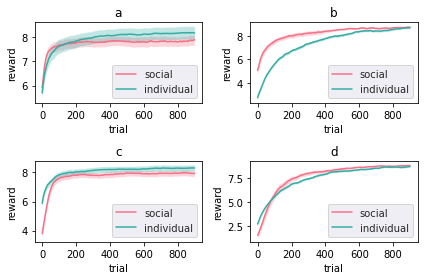

In [ ]:
R1 = resultRc
R1tind = {}
R1tsoc = {}
for x in R1.keys():
    if "individual" in x:
        R1tind[x.replace(" individual", "").replace(" ", "")] =  R1[x]
    else:
        R1tsoc[x.replace(" Social", "").replace(" ", "")] =  R1[x]
t = {'c':[1,0],'d':[1,1],'a':[0,0],'b':[0,1]}
fig, ax = plt.subplots(2,2)
for (k, ij) in zip(R1tind.keys(),t.keys()):
    data = {}
    data["social"] = R1tsoc[k]
    data["individual"] = R1tind[k]
    clrs = sns.color_palette("husl", len(data.keys()))
    with sns.axes_style("darkgrid"):
            epochs = list(range(900))
            for (x, c) in zip(data.keys(),clrs):
                temp = [[np.mean(d[w:w+100]) for w in range(len(d)-100)] for d in data[x]]
                meanst = np.mean(temp,axis = 0)
                sdt = 2*np.std(temp, axis = 0, ddof = 0)/np.sqrt(np.shape(temp)[0])
                ax[t[ij][0], t[ij][1]].plot(epochs, meanst, label=x, c=c)
                ax[t[ij][0], t[ij][1]].fill_between(epochs, meanst-sdt, meanst+sdt ,alpha=0.3, facecolor=c)
            ax[t[ij][0], t[ij][1]].set_xlabel("trial")
            ax[t[ij][0], t[ij][1]].set_ylabel("reward")
            ax[t[ij][0], t[ij][1]].set_title(ij)
            ax[t[ij][0], t[ij][1]].legend()
fig.tight_layout()
plt
fig.savefig("./gdrive/MyDrive/logt/subplot1.pdf", dpi=1200, bbox_inches="tight")
plt.show()

#### Part B : detecting good agents

In [ ]:
thompson_agent = 0
percent_agents = 4
p = [0, 0, 0.1, 0.9]
increase = [0.01, 0.005, 0.001, -0.1]
limit = [0.8, 1, 1, 1]
worst_agents = 0
random_agents = 100
k = [10]
rewards, vars = create_means(n = k, rewards=[(i-100)/10 for i in range(200)], repeate = epoch)
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning(SocialAgent,society, greedyAgent)
sl.loop(iteration = 10,rewards= rewards, vars=vars)

In [ ]:
data1 = sl.compare()
tools().save(data1,'./gdrive/MyDrive/logt/detectingC1.npy')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
thompson_agent = 0
percent_agents = 4
p = [0.1, 0, 0, 0.3]
increase = [0.01, 0.005, 0.001, 0.0001]
limit = [0.4, 0.6, 1, 0.5]
worst_agents = 0
random_agents = 100
n = [10]
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning(SocialAgent,society, greedyAgent)
sl.loop(iteration = 10,rewards= rewards, vars=vars)

In [ ]:
data2 = sl.compare()
tools().save(data2,'./gdrive/MyDrive/logt/detectingC2.npy')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Mounted at /content/gdrive
Mounted at /content/gdrive
Mounted at /content/gdrive
Mounted at /content/gdrive


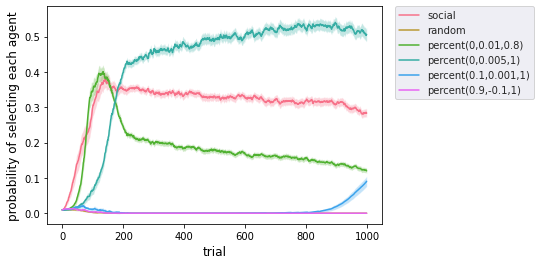

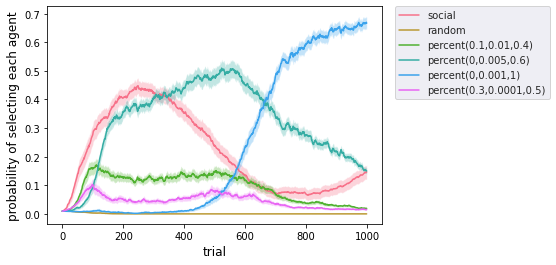

In [ ]:
tools().Visual(data1["preference"],line = False , save = True, limit = False, name = './gdrive/MyDrive/logt/detectingpreferenceC1.pdf', label = "probability of selecting each agent")
tools().Visual(data2["preference"],line = False , save = True, limit = False, name = './gdrive/MyDrive/logt/detectingpreferenceC2.pdf', label = "probability of selecting each agent")

#### Part C : compare to other

In [122]:
class SocialLearning1:
    def __init__(self, learner, society, individual, k_n_thr = 0, limit = 10000, beta1 = None, beta2 = None):
        self.learner = learner
        self.society = society
        self.individual = individual
        self.history = []
        self.historyR = []
        self.historyindividual = []
        self.historyindividualR = []
        self.best = []
        self.bestR = []
        self.preference_history = {}
        self.id = 0
        self.k_n_thr = k_n_thr
        self.limit = limit
        self.beta1=  beta1
        self.beta2 = beta2

    def iteration(self, env, trial_cnt, preferencelearner, threshold = 1000, noize = 0):
        self.society.reset(env)
        history = []
        historyR = []
        historyindividual = []
        historyindividualR = []
        if env.arm_count/len(self.society.agents) > self.k_n_thr:
            if self.beta1 is not None:
                socialLearner = self.learner(len(self.society.agents), env, c_level = 0.9, beta1 = self.beta1, beta2 = self.beta2)
            else:
                socialLearner = self.learner(len(self.society.agents), env, c_level = 0.9)
            self.id = socialLearner.id
        else:
            socialLearner = self.individual(environment = env,id = 0)
        for i in range(trial_cnt):
            self.society.step()
            obs, Ri, index_selected_arm = socialLearner.take_action()
            history.append(index_selected_arm)
            historyR.append(env.rewards[index_selected_arm].m)
        if env.arm_count/len(self.society.agents) > self.k_n_thr:
            for i in range(len(socialLearner.preference_history)):
                self.preference_history[i].append(socialLearner.preference_history[i])
        individualLearner = self.individual(environment = env,id = 0)
        for i in range(trial_cnt):
            obs, Ri, index_selected_arm = individualLearner.take_action()
            historyindividual.append(index_selected_arm)
            historyindividualR.append(env.rewards[index_selected_arm].m)
        self.historyindividual.append(historyindividual)
        self.historyindividualR.append(historyindividualR)
        self.society.historyRecord()
        self.history.append(history)
        self.historyR.append(historyR)
    def loop(self, epoch = 10, iteration = 10, vars = [], rewards = [(i-100)/10 for i in range(200)], threshold = 1000, noize = 0, n = [100], reward_var = None, reward_means = None, random_reward = True, k = None, preferencelearner = None):
        for i in range(len(self.society.historyTotal.keys())+1):
            self.preference_history[i] = []
        for (reward_means,reward_var) in zip(rewards, vars):
            for i in range(iteration):
                env = NArmedBanditEnvironment(len(reward_means), reward_means, reward_var)
                self.iteration(env, 1000, preferencelearner)
                self.best.append(np.argmax(reward_means))
                self.bestR.append(reward_means[np.argmax(reward_means)])
    def optimalaction(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [0]
            for index_selected_arm in hist[i]:
                temp.append(temp[-1]+int(index_selected_arm==self.best[i]))
            temp = temp[1:]
            for t in range(len(temp)):
                temp[t] = temp[t]/(t+1)
            poa.append(temp)
        return poa
    def regret(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [((j+1)*self.bestR[i]-np.sum(hist[i][0:j])) for j in range(len(hist[i]))]
            poa.append(temp)
        return poa
    def regretc(self, hist):
        poa = []
        for i in range(len(hist)):
            temp = [(self.bestR[i]-hist[i][j]) for j in range(len(hist[i]))]
            poa.append(temp)
        return poa
    def compare(self, all = False):
        if all:
            index = [i for i in range(len(self.society.agents))]
        else:
            index = self.society.getCategories()
        data = {}
        data["history action"] = self.history
        data["history reward"] = self.historyR
        data["index"] = index
        data["history individual action"] = self.historyindividual
        data["history individual reward"] = self.historyindividualR
        data["optimal action"] = self.best
        data["optimal action reward"] = self.bestR
        tmp = {}
        tmp["social"] = self.preference_history[self.id]
        for i in index:
            tmp[self.society.names[i]] = self.preference_history[i]
        data["preference"] = tmp
        poa = {}
        poa["social"] = self.optimalaction(self.history)
        poa["individual"] = self.optimalaction(self.historyindividual)
        for i in index:
            poa[self.society.names[i]] = self.optimalaction(self.society.historyTotal[i])
        data["percent of selecting the optimal action"] = poa
        poa = {}
        poa["social"] = self.regret(self.historyR)
        poa["individual"] = self.regret(self.historyindividualR)
        data["regret"] = poa
        poa = {}
        poa["social"] = self.regretc(self.historyR)
        poa["individual"] = self.regretc(self.historyindividualR)
        data["regretc"] = poa
        return data

In [123]:
class  OUCB:    
    def __init__(self, id, environment, c_level = 0.9, beta1 = 0.5, beta2 = 0.5):
        self.environment = environment
        self.environment.add_agent()
        self.Q_value   = np.zeros(environment.arm_count)
        self.T   = np.ones(environment.arm_count) * 1000
        self.action_counts = np.zeros(environment.arm_count)
        self.UCB_action_count = np.ones((len(self.environment.agents_last_choice),environment.arm_count))
        self.id = id
        self.n = 1
        self.c_level = c_level
        self.preference_history = {}
        self.beta1 = beta1
        self.beta2 = beta2
        for i in range(len(self.environment.agents_last_choice)):
            self.preference_history[i] = []
        
    def update_arm(self, Ri, index_selected_arm):
        self.Q_value[index_selected_arm] = self.Q_value[index_selected_arm] * self.T[index_selected_arm] + Ri 
        self.T[index_selected_arm] = self.T[index_selected_arm] + 1  
        self.Q_value[index_selected_arm] = self.Q_value[index_selected_arm]/ self.T[index_selected_arm]
        return self.Q_value, self.T     
    def select_action(self):
        #calculate sqrt
        temp_action_count = np.mean(self.UCB_action_count, axis =0)
        ucb = []
        for i in range(len(self.T)):
            if self.T[i] !=0 :
                target_term = (temp_action_count[i] - self.action_counts[i]) / np.sum(self.T)
                target_optimism = target_term if target_term>0 else 0
                ucb.append(self.Q_value[i] + self.c_level * np.sqrt(2*np.log(np.sum(self.T))/self.action_counts[i]) * (self.beta1 + self.beta2*target_optimism))
            else:
                ucb.append(np.inf)
        return np.argmax(ucb)
    def take_action(self):
        for i in range(len(self.environment.agents_last_choice)):
            self.UCB_action_count[i][self.environment.agents_last_choice[i]] += 1
        
        index_selected_arm = self.select_action()
        self.action_counts[index_selected_arm] += 1
        # print(index_selected_arm, self.id, "target")
        obs, Ri = self.environment.step(index_selected_arm, self.id)
        self.Q_value, self.T =self.update_arm(Ri, index_selected_arm)
        return obs, Ri, index_selected_arm

In [37]:
resultindividual = {}
resultsocial = {}
resultdifference = {}
epoch = +30
k = 10
rewards, vars = create_means(n = [k], rewards=[(i-100)/10 for i in range(200)], repeate = epoch)

In [38]:
result = {}
resultR = {}
resultRc = {}
thompson_agent = 1
percent_agents = 0
p = [0.01]
increase = [0.005]
limit = [0.9]
worst_agents = 0
random_agents = 100

In [39]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning(SocialAgent,society, greedyAgent)
sl.loop(iteration = 10,rewards= rewards, vars=vars)

In [40]:
data = sl.compare()
result["preference based"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["preference based"] = np.array(data["regret"]["social"])

In [42]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning1(OUCB,society, greedyAgent, beta1 = 0.5, beta2 = 0.5)
sl.loop(iteration = 10,rewards= rewards, vars=vars)
data = sl.compare()
result["OUCB (0.5, 0.5)"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["OUCB (0.5, 0.5)"] = np.array(data["regret"]["social"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


In [43]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning1(OUCB,society, greedyAgent, beta1 = 0.1, beta2 = 0.9)
sl.loop(iteration = 10,rewards= rewards, vars=vars)
data = sl.compare()
result["OUCB (0.1, 0.9)"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["OUCB (0.1, 0.9)"] = np.array(data["regret"]["social"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


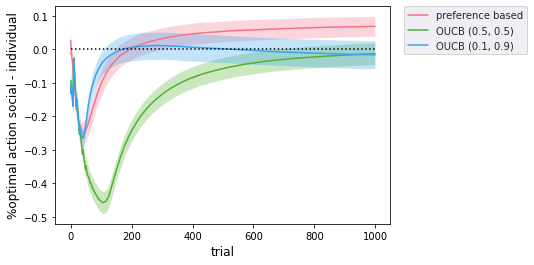

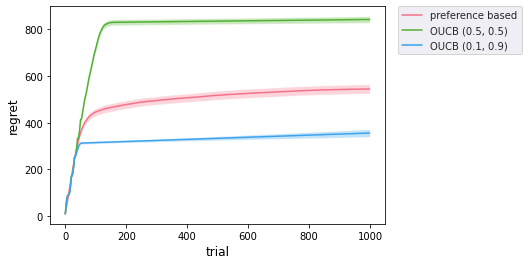

In [92]:
tools().Visual(result, save = True, limit = False, name = './gdrive/MyDrive/logt/comparetargerucb1learner_10arm100random.jpg', label = "%optimal action social - individual")
tools().save(resultR,'./gdrive/MyDrive/logt/comparetargerucb1learner_10arm100randomR.npy')
tools().save(result,'./gdrive/MyDrive/logt/comparetargerucb1learner_10arm100random.npy')
tools().Visual(resultR, save = True, line = False, limit = False, name = './gdrive/MyDrive/logt/comparetargerucb1learner_10arm100randomR.pdf', label = "regret")

In [ ]:
resultindividual = {}
resultsocial = {}
resultdifference = {}
epoch = +30
k = 100
rewards, vars = create_means(n = [k], rewards=[(i-100)/10 for i in range(200)], repeate = epoch)

In [ ]:
result = {}
resultR = {}
resultRc = {}
thompson_agent = 1
percent_agents = 0
p = [0.01]
increase = [0.005]
limit = [0.9]
worst_agents = 0
random_agents = 100

In [ ]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning(SocialAgent,society, greedyAgent)
sl.loop(iteration = 10,rewards= rewards, vars=vars)

In [ ]:
data = sl.compare()
result["preference based"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["preference based"] = np.array(data["regret"]["social"])

In [ ]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning1(OUCB,society, greedyAgent, beta1 = 0.5, beta2 = 0.5)
sl.loop(iteration = 10,rewards= rewards, vars=vars)
data = sl.compare()
result["OUCB (0.5, 0.5)"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["OUCB (0.5, 0.5)"] = np.array(data["regret"]["social"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning1(OUCB,society, greedyAgent, beta1 = 0.1, beta2 = 0.9)
sl.loop(iteration = 10,rewards= rewards, vars=vars)
data = sl.compare()
result["OUCB (0.1, 0.9)"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["OUCB (0.1, 0.9)"] = np.array(data["regret"]["social"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


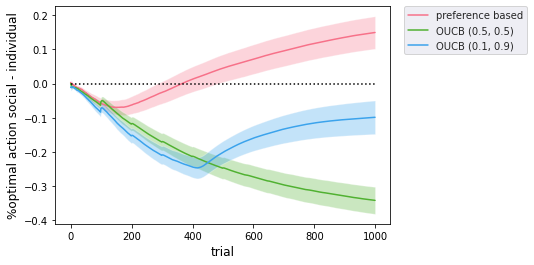

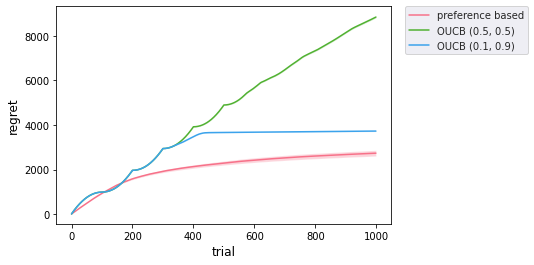

In [94]:
tools().Visual(result, save = True, limit = False, name = './gdrive/MyDrive/logt/comparetargerucb1learner_100arm100random.jpg', label = "%optimal action social - individual")
tools().save(resultR,'./gdrive/MyDrive/logt/comparetargerucb1learner_100arm100randomR.npy')
tools().save(result,'./gdrive/MyDrive/logt/comparetargerucb1learner_100arm100random.npy')
tools().Visual(resultR, save = True, line = False, limit = False, name = './gdrive/MyDrive/logt/comparetargerucb1learner_100arm100randomR.pdf', label = "regret")

In [128]:
resultindividual = {}
resultsocial = {}
resultdifference = {}
epoch = +30
k = 10
rewards, vars = create_means(n = [k], rewards=[(i-100)/10 for i in range(200)], repeate = epoch)

In [129]:
result = {}
resultR = {}
resultRc = {}
thompson_agent = 1
percent_agents = 0
p = [0.9]
increase = [0.0]
limit = [0.9]
worst_agents = 0
random_agents = 0

In [130]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning(SocialAgent,society, UCB)
sl.loop(iteration = 10,rewards= rewards, vars=vars)

In [131]:
data = sl.compare()
result["preference based"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["preference based"] = np.array(data["regret"]["social"])

In [132]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning1(OUCB,society, greedyAgent)
sl.loop(iteration = 10,rewards= rewards, vars=vars)
data = sl.compare()
result["OUCB (0.5, 0.5)"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["OUCB (0.5, 0.5)"] = np.array(data["regret"]["social"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


In [133]:
society = Sciety(thompson_agent = thompson_agent, percent_agents = percent_agents, p=p, increase = increase, limit = limit, worst_agents = worst_agents, random_agents = random_agents)
sl = SocialLearning1(OUCB,society, greedyAgent, beta1 = 0.1, beta2 = 0.9)
sl.loop(iteration = 10,rewards= rewards, vars=vars)
data = sl.compare()
result["OUCB (0.1, 0.9)"] = np.array(data["percent of selecting the optimal action"]["social"])-np.array(data["percent of selecting the optimal action"]["individual"])
resultR["OUCB (0.1, 0.9)"] = np.array(data["regret"]["social"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


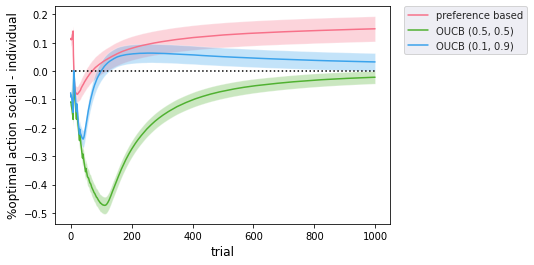

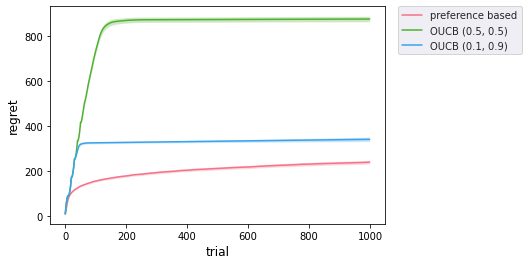

In [134]:
tools().Visual(result, save = True, limit = False, name = './gdrive/MyDrive/logt/comparetargerucb1learner_10arm1l.jpg', label = "%optimal action social - individual")
tools().save(resultR,'./gdrive/MyDrive/logt/comparetargerucb1learner_10arm1lR.npy')
tools().save(result,'./gdrive/MyDrive/logt/comparetargerucb1learner_10arm1l.npy')
tools().Visual(resultR, save = True, line = False, limit = False, name = './gdrive/MyDrive/logt/comparetargerucb1learner_10arm1l.pdf', label = "regret")